<a   href="https://colab.research.google.com/github/eduardojdiniz/Buzznauts/blob/7545997973bbd34bc675c27391685bc82fa16332/scripts/Example_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example loader

### Import Buzznauts GitHub Repository and Install Dependencies

In [3]:
!pip install duecredit --quiet
!pip install nilearn --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install nibabel --quiet
!pip install decord --quiet
!pip install tqdm --quiet


!pip install opencv --quiet
!git clone https://github.com/eduardojdiniz/Buzznauts --quiet
!git clone https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit.git

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv
fatal: destination path 'Buzznauts' already exists and is not an empty directory.
fatal: destination path 'Algonauts2021_devkit' already exists and is not an empty directory.


### Import Buzznauts Module 

In [4]:
import Buzznauts.Buzznauts as buzz
# Imports
import os
import glob
import pickle
import torch

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from nilearn import datasets
from nilearn import plotting
from tqdm import tqdm

fsaverage = datasets.fetch_surf_fsaverage()

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [5]:
# @title Enter the dropbox link
dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1' # @param {type:"string"}

In [6]:
# @title Run the cell
import requests, zipfile, io

# Use the dropbox link to download the data
print(f"Dropbox link: {dropbox_link}")

if dropbox_link:
  fname1 = 'participants_data_v2021'
  fname2 = 'AlgonautsVideos268_All_30fpsmax'
  if not os.path.exists(fname1) or not os.path.exists(fname2):
    print('Data downloading...')
    r = requests.get(dropbox_link)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print('Data download is completed.')
  else:
    print('Data are already downloaded.')


  url = 'https://github.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/raw/main/example.nii'
  fname = 'example.nii'
  if not os.path.exists(fname):
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
  else:
    print(f"{fname} file is already downloaded.")

else:
  print('You need to submit the form and get the dropbox link')

Dropbox link: https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=1
Data are already downloaded.
example.nii file is already downloaded.


In [8]:
# @title Utility functions for data loading
def save_dict(di_, filename_):
  with open(filename_, 'wb') as f:
      pickle.dump(di_, f)

def load_dict(filename_):
  with open(filename_, 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    ret_di = u.load()
    # print(p)
    # ret_di = pickle.load(f)
  return ret_di


def visualize_activity(vid_id,sub):
  # Setting up the paths for whole brain data
  fmri_dir = './participants_data_v2021'
  track = "full_track"

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)

  # get the selected subject's directory
  sub_fmri_dir = os.path.join(track_dir, sub)

  #result directory to store nifti file
  results_dir = '/content/'

  # mapping the data to voxels and storing in a nifti file
  fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,"WB")
  visual_mask_3D = np.zeros((78,93,71))
  visual_mask_3D[voxel_mask==1]= fmri_train_all[vid_id,:]
  brain_mask = './example.nii'
  nii_save_path =  os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask,nii_save_path,visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title='fMRI response',plot_abs=False,
                          display_mode='lyr',colorbar=True)


def get_fmri(fmri_dir, ROI):
  """This function loads fMRI data into a numpy array for to a given ROI.
  Parameters
  ----------
  fmri_dir : str
    path to fMRI data.
  ROI : str
    name of ROI.

  Returns
  -------
  np.array
    matrix of dimensions #train_vids x #repetitions x #voxels
    containing fMRI responses to train videos of a given ROI
  """

  # Loading ROI data
  ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
  ROI_data = load_dict(ROI_file)
  # averaging ROI data across repetitions
  ROI_data_train = np.mean(ROI_data["train"], axis=1)
  if ROI == "WB":
    voxel_mask = ROI_data['voxel_mask']

    return ROI_data_train, voxel_mask

  return ROI_data_train

def saveasnii(brain_mask,nii_save_path,nii_data):
  img = nib.load(brain_mask)
  nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
  nib.save(nii_img, nii_save_path)

In [9]:
os.listdir()

['.config',
 'Buzznauts',
 'Algonauts2021_devkit',
 'example.nii',
 'participants_data_v2021',
 'AlgonautsVideos268_All_30fpsmax',
 'sample_data']

In [41]:
from decord import VideoReader
from decord import cpu, gpu
from tqdm import tqdm
from random import randrange

def load_videos(path_to_videos, random_strategy = 'standard'):
  
  vid_list = os.listdir(path_to_videos)
  vid_list.sort()
  mp4_filename_format = "{path}/{filename}"
  X = {}
  i = 0

  with tqdm(total = len(vid_list), position = 0, leave = True) as pbar:
    for video in tqdm(vid_list, position = 0, leave = True):
      
      mp4_filename = mp4_filename_format.format(path=path_to_videos, 
                                                filename=video)
      vr = VideoReader(mp4_filename, ctx=cpu(0))

      if random_strategy=='standard':
        num_frames = len(vr)
      
        X[i] = vr.get_batch([0, int(num_frames*0.5), num_frames-1])

      elif random_strategy=='random':
        sample_n = np.zeros((3))

        for x in range(sample_n.shape[0]):
          sample_n[x] = randrange(0, len(vr))	

        X[i] = vr.get_batch([int(sample_n[0]), int(sample_n[1]), int(sample_n[2])])

      i += 1

  return X


X = load_videos("AlgonautsVideos268_All_30fpsmax")

  0%|          | 0/1102 [01:03<?, ?it/s]


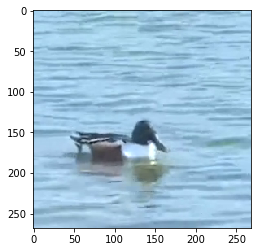

In [39]:
from matplotlib import pyplot as plt
v = X[0]
plt.imshow(v.asnumpy()[1], interpolation='nearest')
plt.show()